## Part 1 ‑ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
# import important stuff
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
# import visulization modules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("talk")
%matplotlib inline

In [3]:
# import stats modules
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency
from scipy.sparse import hstack


In [4]:
# import sklearn modules
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from imblearn.over_sampling import SMOTE

In [5]:
# Read in the data
logins_df = pd.read_json('logins.json')
logins_df.info()
logins_df.head()

# Reset the index adn resample in 15 minute time intervals
logins_df.set_index('login_time', inplace=True)
logins_df['count'] = 1
logins_df_15m = pd.DataFrame(logins_df['count'].resample('15T').sum())

# to date time
logins_dt = pd.to_datetime(logins_df_15m.index)


# set lists of months and days of the week
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


In [6]:
# add month to data
logins_df_15m['month'] = pd.DataFrame(logins_dt.month)['login_time'].apply(lambda x: month_order[x-1]).tolist()

# add day and hour to login data 
logins_df_15m['day'] = pd.DataFrame(logins_dt.day)['login_time'].tolist()
logins_df_15m['hour'] = pd.DataFrame(logins_dt.hour)['login_time'].tolist()

# add week day to data 
logins_df_15m['weekday'] = pd.DataFrame(logins_dt.weekday)['login_time'].apply(lambda x: day_order[x]).tolist()

In [7]:
#logins_df_15m.rename(columns={ logins_df_15m.columns[0]: "count" })
logins_df_15m.head(5)

,count,month,day,hour,weekday
login_time,,,,,
1970-01-01 20:00:00,2.0,Jan,1,20,Thu
1970-01-01 20:15:00,6.0,Jan,1,20,Thu
1970-01-01 20:30:00,9.0,Jan,1,20,Thu
1970-01-01 20:45:00,7.0,Jan,1,20,Thu
1970-01-01 21:00:00,1.0,Jan,1,21,Thu


In [8]:
# check the sum of logins for each month
logins_df_15m.groupby('month')['count'].sum()

month
Apr    13507.0
Feb    24673.0
Jan    21239.0
Mar    33723.0
Name: count, dtype: float64

### Monthly difference  
It seems that the data includes four months worth of logins. The amount of logins climbs steadily from Janurary to March. And we see a sharp decline in April? Why is this? Is April a bad business month or it is merely caused by incompletion of the data collection in April? 

In [9]:
# how many per 15 minutes entires per month? 
logins_df_15m['month'].value_counts()


Mar    2976
Jan    2896
Feb    2688
Apr    1228
Name: month, dtype: int64

Results above shows there are less than half of 15 minute entries in April. It seems to point that April data is incomplete. Now we check in another way, plotting the count of logins per 15 minutes in time series. 

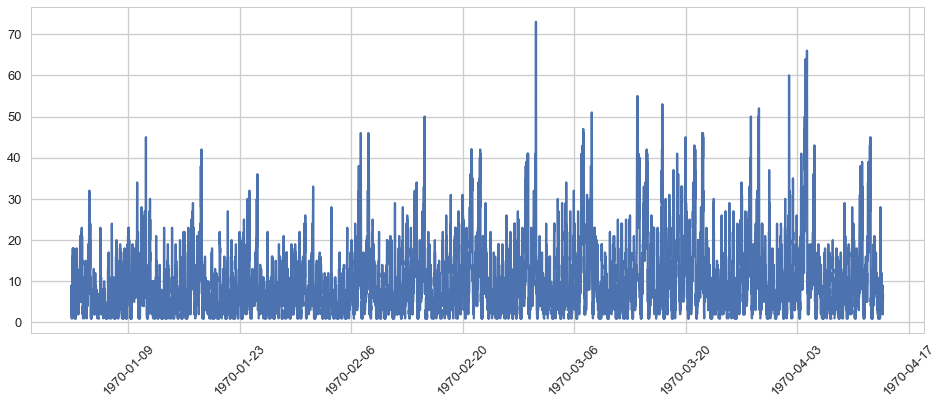

In [10]:
plt.figure(figsize=(16,6))
plt.plot(logins_df_15m['count'])
plt.xticks(rotation=45);

The plot above confirms previous observation, the reason the number of logins in April is lower is because the April data stops on April 14th. It does not make sense to compare the sum of logins if the time frames are different. Now check the average logins per day for each month.

In [11]:
# calculate average logins per day for each month 
logins_df_15m.groupby('month')['count'].sum()/logins_df_15m.groupby('month')['day'].nunique()

month
Apr    1039.000000
Feb     881.178571
Jan     685.129032
Mar    1087.838710
dtype: float64

This result gives reasonable evaluation of user activities in each month. We see a steady increase in average logins per day from Janurary to March and that number stays similar for April.

### Day of the Week Observation

In [12]:
# separate the login data to each month. We can look at one month at a time for convenience. 
logins_jan = logins_df_15m[logins_df_15m['month']=='Jan']
logins_feb = logins_df_15m[logins_df_15m['month']=='Feb']
logins_mar = logins_df_15m[logins_df_15m['month']=='Mar']
logins_apr = logins_df_15m[logins_df_15m['month']=='Apr']

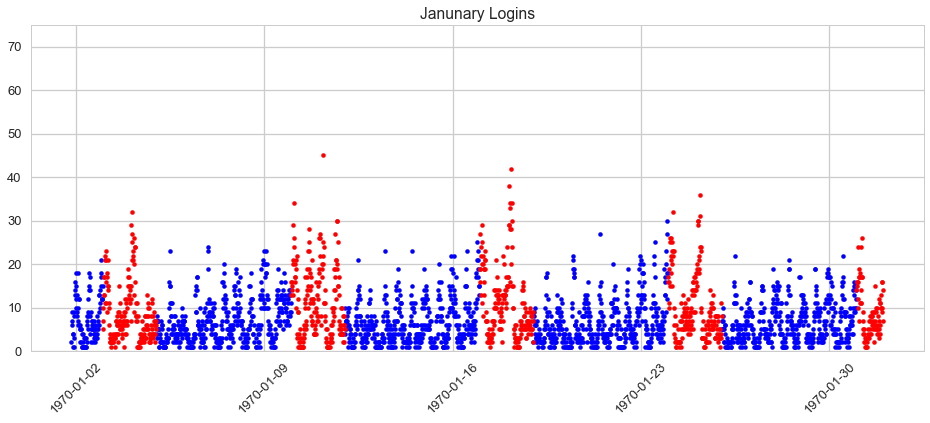

In [13]:
plt.figure(figsize=(16,6)) 

# define a function to plot login with weekend and weekday distinctively. 

def show_trends(df, title):

    for day in sorted(list(df['weekday'].unique())):

        temp = df[df['weekday'] == day]
        
        # Blue for weekday
        if day in ['Thu', 'Fri', 'Mon', 'Tue', 'Wed']:
            color = 'blue'
        # Red for weekend 
        else:
            color = 'red'
        plt.plot(temp['count'],'.', color=color)
        plt.title(title)
        plt.xticks(rotation=45)
        plt.ylim([0,75])

show_trends(logins_jan, "Janunary Logins")


Above is the plot for Janurary logins with different colors for weekdays and weekends. It is shown that there are more activities over the weekend generally, compared with the weekdays. There are also apparent modulation in the logins during the day, it seems that evening and midnight hours during the weekend have the highest logins. The more detailed logins will be studied later in this report. 

Next we plot the same logins for Feburary, March and April. We see pretty similar trends for all months. Again, the amount of logins increases from Januray to March. 

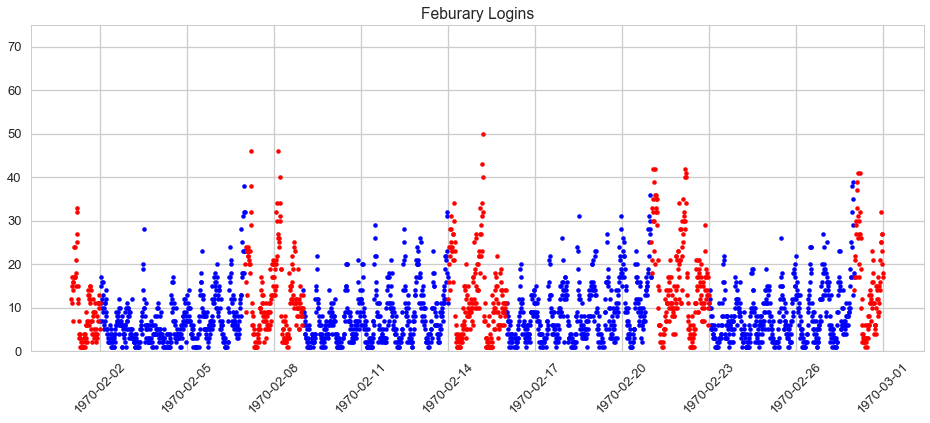

In [14]:
plt.figure(figsize=(16,6)) 
show_trends(logins_feb, "Feburary Logins")


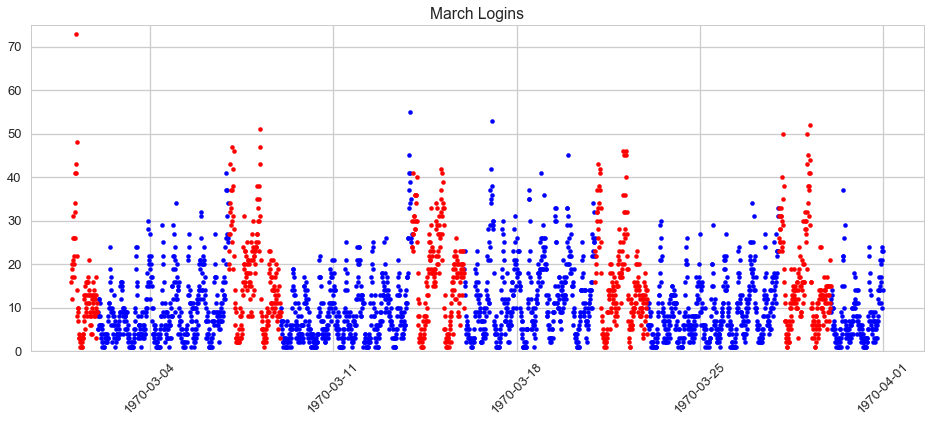

In [15]:
plt.figure(figsize=(16,6)) 
show_trends(logins_mar, "March Logins")


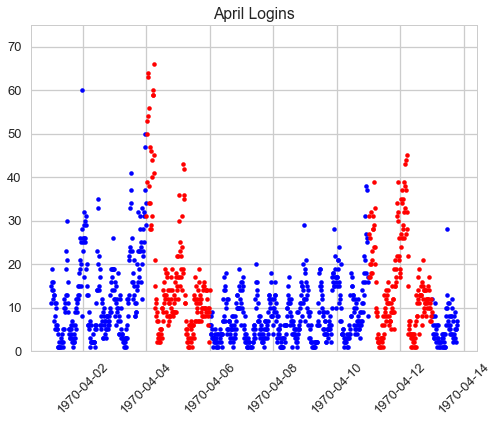

In [16]:
plt.figure(figsize=(8,6)) 
show_trends(logins_apr, "April Logins")

The login data for April is interesting. There is a strong login weekend the first weekend of April, particularly the midnight hours of April fourth. Was there a special event happening or is it caused by a promotion? It is worth digging. 

After that weekend, on the other hand, the logins have been flatly lower. Was ther any error during the busy weekend causing the cooling down of the logins the week after? It is worth digging. 

### Hour of the Day

We saw modulations during the days in the above monthly plot. To show that more clearly, we plot the hourly logins below. We see the modulation during the day: night and lunch hours see increased login activities. On the other hand, morning and afternoon rush hours have the least logins. 

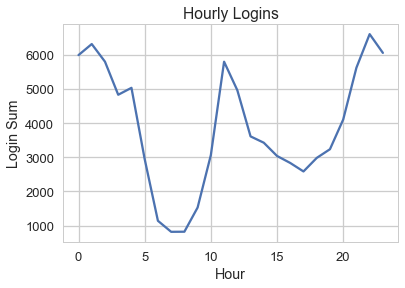

In [17]:
# plot hourly logins
plt.plot(pd.DataFrame(logins_df_15m.groupby('hour')['count'].sum()),'-')
plt.title('Hourly Logins')
plt.xlabel('Hour')
plt.ylabel('Login Sum')

Now we separate the data into weekend and weekday and see if they have similar trends of logins. 

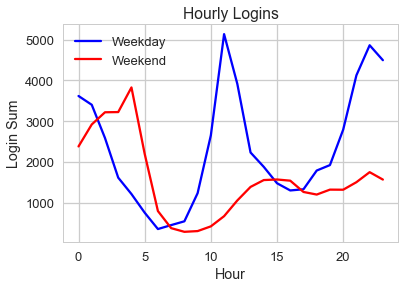

In [18]:
#plt.plot(pd.DataFrame(logins_df_15m.groupby('hour')['count'].sum()),'-')
logins_weekday = logins_df_15m[logins_df_15m['weekday'].isin(['Thu', 'Fri', 'Mon', 'Tue', 'Wed'])]
logins_weekend = logins_df_15m[logins_df_15m['weekday'].isin(['Sat', 'Sun'])]

plt.plot(pd.DataFrame(logins_weekday.groupby('hour')['count'].sum()),'b', label='Weekday')
plt.plot(pd.DataFrame(logins_weekend.groupby('hour')['count'].sum()),'r', label='Weekend')
plt.title('Hourly Logins')
plt.xlabel('Hour')
plt.ylabel('Login Sum')
plt.legend()

It turns out there are the obvious two peaks around night and lunch time for weekdays. During weekend, the lunch logins are way less and the main peak happens a little after mid night. This is very interesting! 


## Part 2: Experiment and metrics design  

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?  
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:  
      a. how you will implement the experiment.  
      b. what statistical test(s) you will conduct to verify the significance of the observation.  
      c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.


Sample answers from David Albrecht, will change later: 

I here choose a metric that describes the percentage of time a driver spends in either city as the key measure of success. At this point, since the drivers tend to be exclusive to both cities, the metric for the average Gotham driver would look something like 100% time in Gotham and 0% time in Metropolis. In a perfectly successful experiment, we would see the metric shift closer to 50% time in Gotham and 50% time in Metropolis. In a less successful experiment, we would see the metric shift closer to 75% time in Gotham and 25% time in Metropolis. If the metric for the average Gotham driver flips to favor time in Metropolis, there is something wrong and we have incentivized time in Metropolis too much and we may see the average Metropolis driver stay in Metropolis and vice versa. Using a metric such as this one allows us to track real activity in the drivers of both cities and the maximization of such a metric results in a balance of time in both cities. 

We should also keep in mind revenue as a secondary metric to look at, since this is usually the main reason for solving a business problem. Using revenue as a main metric, however, can be problematic because the real reasons for movements in revenue are not always apparent. Maximizing revenue may be good for short-term bottom line results, but not great for long-term growth. For example, seeking to maximize revenue may result in incentives to drive in only Gotham or only Metropolis due to increased fares in either city, which would cause us to alienate an entire group of drivers and customers.

The experiment could be set up as below:

Current scenario: Average time split for the average Gotham driver is close to 100% Gotham, 0% Metropolis. Average time split for the average Metropolis driver is close to 100% Metropolis, 0% Gotham.  Goal: Push the average time split for both the average Gotham driver and average Metropolis closer to 50% Gotham, 50% Metropolis.

The experiment consists of offering full reimbursements to all toll costs, and can be tested during two times of the year: 1) when it is easy to drive (summer) and 2) when it is difficult to drive (winter). For the purposes of this challenge, let's focus on a typical summer month when the experiment will be run for one month.

We can measure the results of the experiment with a one-tailed z-test where we can test whether the average Gotham driver's time spent in Gotham is meaningfully below 100% and whether the average Metropolis driver's time spent in Metropolis is meaningully below 100%. Alternatively, we could also test whether either time spent is meaningfully above 0% outside of a driver's native city. A one-tailed test is appropriate since we want to test whether the average percent of time has changed to either above 0% or below 100% (depending on the scenario we want to test as described previously). A z-test is appropriate because we can obtain a rather large sample size (easily >30) and we likely know or can find the population's standard deviation under normal operation.

We can interpret the results in the form of a confidence interval. To be safe, a 95% confidence interval could be useful. In this way, we can present our findings such as: We are 95% confident that the mean percent of time the average Gotham driver spends driving in Gotham has dropped to 75% give or take 5%. In this way we can easily show whether the test worked and whether drivers from each city are spending more time outside of their native cities. Two caveats, as described when exploring metrics, might be that:

Profits may have dropped depending on how many drivers move between each city. It is possible that, since demand for drivers has not been increased, profits will drop because the company is now reimbursing toll expenses while not increasing revenue. This may be of lesser concern because our main goal is to incentivize drivers to operate in both cities.
We may find that we incentivised too well. For example, if we are 95% confident that the mean percent of time the average Gotham driver spends driving in Gotham has dropped to 35% give or take 5%, we could see that the metric for Metropolis drivers has not moved meaningfully. In this case, we should incentivize differently since it may not always be a good thing that the metrics have move in a statistically significant way.

## Part 3: Predictive modeling  

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?  
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.  
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

In [19]:
# import the data
import json

file = open('ultimate_data_challenge.json', 'r')
df = pd.DataFrame(json.load(file))
file.close()

print(df.head())
print(df.info())

   avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3  King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4      Winterfell     2014-03-15  Android  2014-01-27       11.8   

   trips_in_first_30_days  ultimate_black_user  weekday_pct  
0                       4                 True         46.2  
1                       0                False

In [20]:
# change object date and time columns to data using pandas. 
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

### Clean data 

Fill in missing values in columns 'avg_rating_by_driver', 'avg_rating_of_driver', and 'phone'. To simplify the problem, fill in the average value for the null entries for ratings and majority of entry for 'phone'. 

In [21]:
# decide missing values
arbd = df['avg_rating_by_driver'].mean()
arod = df['avg_rating_of_driver'].mean()
phn = df['phone'].value_counts().reset_index().iloc[0, 0]

# fill in missing values

df['avg_rating_by_driver'].fillna(arbd, inplace=True)
df['avg_rating_of_driver'].fillna(arod, inplace=True)
df['phone'].fillna(phn, inplace=True)

# check df now: 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [22]:
# define column types for easy manipulations
categorical = ['city', 'phone', 'ultimate_black_user']
dt = ['last_trip_date', 'signup_date']
numerical = df.columns.difference(categorical+dt)

                        avg_dist  avg_rating_by_driver  avg_rating_of_driver  \
avg_dist                1.000000              0.079793              0.028508   
avg_rating_by_driver    0.079793              1.000000              0.101660   
avg_rating_of_driver    0.028508              0.101660              1.000000   
avg_surge              -0.081491              0.010498             -0.021653   
surge_pct              -0.104414              0.019964             -0.003290   
trips_in_first_30_days -0.136329             -0.039097             -0.011060   
ultimate_black_user     0.032310              0.009328             -0.001916   
weekday_pct             0.101652              0.020366              0.012587   

                        avg_surge  surge_pct  trips_in_first_30_days  \
avg_dist                -0.081491  -0.104414               -0.136329   
avg_rating_by_driver     0.010498   0.019964               -0.039097   
avg_rating_of_driver    -0.021653  -0.003290               -0.0

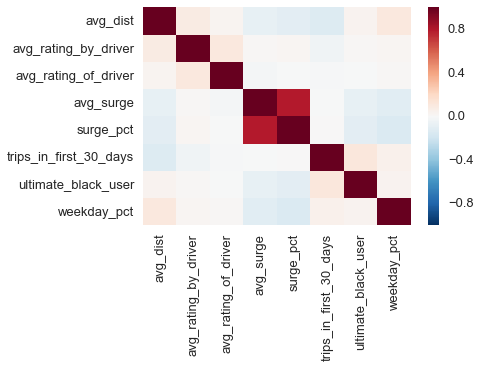

In [23]:
# Show the correlation matrix
corr_matrix = df.corr()
print(corr_matrix)
sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values)


We see that surge_pct and avg_surge are highly correlated with eachother at 0.79, and this makes sense given these two features are highly related to there being a surge or not. Since there are not too many features in this dataset, we will keep these two features.

In [24]:
# find the last trip date in the dataset
sorted(df['last_trip_date'].unique())[-10:]

[numpy.datetime64('2014-06-22T00:00:00.000000000'),
 numpy.datetime64('2014-06-23T00:00:00.000000000'),
 numpy.datetime64('2014-06-24T00:00:00.000000000'),
 numpy.datetime64('2014-06-25T00:00:00.000000000'),
 numpy.datetime64('2014-06-26T00:00:00.000000000'),
 numpy.datetime64('2014-06-27T00:00:00.000000000'),
 numpy.datetime64('2014-06-28T00:00:00.000000000'),
 numpy.datetime64('2014-06-29T00:00:00.000000000'),
 numpy.datetime64('2014-06-30T00:00:00.000000000'),
 numpy.datetime64('2014-07-01T00:00:00.000000000')]

In [25]:
print('{:.2f}% of users have taken a trip on or after June 1st, 2014 and are considered \'retained\'.'.format(len(df[df['last_trip_date'] >= '2014-06-01'])/len(df)*100))

37.61% of users have taken a trip on or after June 1st, 2014 and are considered 'retained'.


### Build a predictive model 
To help Ultimate determine whether or not a user will be active in their 6th month on the system, we build a predictive model. 
I begin by creating the target variable for a binary classification of retained or not retained:

In [26]:
# Create the target feature: retained or not by checking if the user has taken a trip in the last 30 days

ls = []
deadline = datetime.strptime('2014-06-01', '%Y-%m-%d')


for date in df['last_trip_date']:
    if date >= deadline:
        ls.append(1)
    else:
        ls.append(0)
        
df['retained'] = ls

# add day of the week into the data frame as a categorical feature


ls_weekday = df['last_trip_date'].dt.weekday.apply(lambda x: day_order[x]).tolist()
ls_weekend = []

for i in ls_weekday:
    if i in ['Thu', 'Fri', 'Mon', 'Tue', 'Wed']:
        ls_weekend.append(0)
    else:
        ls_weekend.append(1)

df['weekend last ride'] = ls_weekend

In [27]:
print(df['retained'].value_counts())

# Drop last trip date to prepare for predictive models
df_class = df.drop(['last_trip_date', 'signup_date'], axis=1)

0    31196
1    18804
Name: retained, dtype: int64


In [28]:
df_dummy = pd.get_dummies(df_class, columns = categorical)

df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
avg_dist                     50000 non-null float64
avg_rating_by_driver         50000 non-null float64
avg_rating_of_driver         50000 non-null float64
avg_surge                    50000 non-null float64
surge_pct                    50000 non-null float64
trips_in_first_30_days       50000 non-null int64
weekday_pct                  50000 non-null float64
retained                     50000 non-null int64
weekend last ride            50000 non-null int64
city_Astapor                 50000 non-null uint8
city_King's Landing          50000 non-null uint8
city_Winterfell              50000 non-null uint8
phone_Android                50000 non-null uint8
phone_iPhone                 50000 non-null uint8
ultimate_black_user_False    50000 non-null uint8
ultimate_black_user_True     50000 non-null uint8
dtypes: float64(6), int64(3), uint8(7)
memory usage: 3.8 MB


In [29]:

# Identify variables
X = df_dummy.drop('retained', axis=1)
y = df_dummy.retained

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=41)


rus = RandomUnderSampler(random_state=41)
X_rus, y_rus = rus.fit_sample(X=X_train, y=y_train)
X_rus_test, y_rus_test = rus.fit_sample(X=X_test, y=y_test)

print('Raw Training Set Percent Retained: {:.1f}%'.format(
    len(y_train[y_train == 1])/len(y_train)*100))
print('Resampled Training Set Percent Retained: {}%'.format(
    len(y_rus[y_rus == 1])/len(y_rus)*100))

Raw Training Set Percent Retained: 37.6%
Resampled Training Set Percent Retained: 50.0%


#### Random Forest Classifier to predict whether the user is retained or not. 

Using grid search and cross validation on the train test data to optimize parameters of the random forest model. 

In [30]:
#Random forest classifier parameter optimization:

rf = RandomForestClassifier()
param_grid = {"n_estimators": [50, 100, 200],
              "max_features": [1, 3, 10],
              "max_depth": [3, 10, 20]
              }

grid_rf = GridSearchCV(rf, param_grid=param_grid, cv=5)
grid_rf.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_rf.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_rf.best_params_
print('Best Parameters:', best_params)

Best Score: 0.766814551908
Best Parameters: {'max_depth': 10, 'max_features': 3, 'n_estimators': 50}


In [31]:
#initiate a instance for classifier, use the best parameters found from the last step

rf = RandomForestClassifier(**best_params)

# Fit the classifier to the training data
rf.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = rf.predict(X_test)

scores_rf_train = cross_val_score(rf, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_rf_train.mean(), 
                                                                                 scores_rf_train.std()*2))
scores_rf_test = cross_val_score(rf, X_test, y_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_rf_test.mean(), 
                                                                                 scores_rf_test.std()*2))

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.76566(+/- 0.03)
Cross Validation Accuracy Scores - Test Set: 0.78486(+/- 0.01)
Confusion matrix on the test data:
[[16971  4860]
 [ 3258  9911]]
Classification report on the test data:
             precision    recall  f1-score   support

          0       0.84      0.78      0.81     21831
          1       0.67      0.75      0.71     13169

avg / total       0.78      0.77      0.77     35000




The random forest gives an accuracy of 0.78. It does a fairly good job of determining the difference between a retained and not retained user as shown by the confusion matrix. Now let's check which features are more important determining the target feature using the random forest classifier. 

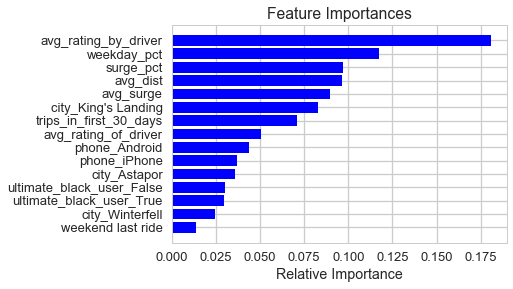

In [32]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

As shown above, the top three determining features are "ave_rating_by_driver", "weekday_pct", and "surge_pct". These features are first features to consider if the company wants to improve user activity. 